In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as M
from torch.utils.data import Dataset
from scipy import integrate

In [3]:
class GRU(torch.nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, per_timestep_readout=True, sigma=0.01):
        super().__init__()

        self.per_timestep_readout = per_timestep_readout
        # Gaussian random init with standard deviation *sigma*
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)

        # It is easier to initialize it this way since we always need to worry about
        # (1) projections from the inputs, (2) projections from the latent state, and (3) the bias
        # Note that unlike biological RNNs, we **do not** introduce stochasticity in the activities
 
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))

        # create the parameters for the update gate
        self.W_xz, self.W_hz, self.b_z = triple()

        # create the parameters for the reset gate
        self.W_xr, self.W_hr, self.b_r = triple()

        # hidden state parameters
        self.W_xh, self.W_hh, self.b_h = triple()

        # readout layer parameters
        self.fc = nn.Linear(num_hiddens, num_outputs)
        self.relu = nn.ReLU()

    ''' Given that our parent class is nn.Module, what we are doing here is essentially *overloading*
    This is the function that will be called when we pass a batch of inputs to the GRU
    '''
    def forward(self, inputs, H=None):
        matmul_H = lambda A, B: torch.matmul(A, B) if H is not None else 0
        outputs = []
        readouts = []

        for X in inputs:
            Z = torch.sigmoid(torch.matmul(X, self.W_xz) + (
                torch.matmul(H, self.W_hz) if H is not None else 0) + self.b_z)
            if H is None: H = torch.zeros_like(Z)
            R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                            torch.matmul(H, self.W_hr) + self.b_r)
            H_tilda = torch.tanh(torch.matmul(X, self.W_xh) +
                               torch.matmul(R * H, self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilda
            outputs.append(H)

            if self.per_timestep_readout:
                readouts.append(self.fc(self.relu(H)))

        if not self.per_timestep_readout:
            # final timestep readout layer
            readouts.append(self.fc(self.relu(H)))

        return outputs, readouts

    def single_step(self, X, H):
        matmul_H = lambda A, B: torch.matmul(A, B)

        Z = torch.sigmoid(torch.matmul(X, self.W_xz) + (
            torch.matmul(H, self.W_hz) if H is not None else 0) + self.b_z)
        
        R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                        torch.matmul(H, self.W_hr) + self.b_r)
        
        H_tilda = torch.tanh(torch.matmul(X, self.W_xh) +
                           torch.matmul(R * H, self.W_hh) + self.b_h)
        
        H = Z * H + (1 - Z) * H_tilda

        return H, self.fc(self.relu(H))


In [9]:
class FitzhughNagumo(Dataset):
    def __init__(self, N, T, I=0.5, a=0.7, b=0.8):
        self.I = I
        self.a = a
        self.b = b
        self.N = N
        self.T = T

        data_x = []
        data_y = []
        for i in range(N):
            t = np.linspace(0,400,T+1)
            x0 = np.array([float(np.random.rand(1))*2.-1.,0.])
            sol = integrate.solve_ivp(self.FHN_rhs, [0,400], x0, t_eval=t)
            data_x.append(sol.y[0,:-1])
            data_y.append(sol.y[0,1:])

        self.data_x = np.array(data_x).reshape(N,T,1)
        self.data_y = np.array(data_y).reshape(N,T,1)

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, idx):
        return torch.Tensor(self.data_x[idx]), torch.Tensor(self.data_y[idx])

    def FHN_rhs(self, t,x):
        I, a, b = self.I, self.a, self.b
        eps = 1./50.
        dim1 = x[0] - (x[0]**3)/3. - x[1] + I
        dim2 = eps*(x[0] + a - b*x[1])
        out = np.stack((dim1,dim2)).T

        return out

    def get_init(self):
        t = np.linspace(0,400,self.T+1)
        x0 = np.array([float(np.random.rand(1))*2.-1.,0.])
        sol = integrate.solve_ivp(self.FHN_rhs, [0,400], x0, t_eval=t)
        init_x = sol.y[0, :50]
        return init_x

class FitzhughNagumoClassification(Dataset):
    def __init__(self, N, T):

        # Let's sample data from two distinct dynamical systems
        classA = FitzhughNagumo(N=N, T=T, I=0.5, a=0.95, b=0.2)
        classB = FitzhughNagumo(N=N, T=T, I=0.5, a=0.7, b=0.2)
       
        # now let's create the dataset with appropriate class labels
        self.data = torch.Tensor(np.vstack([classA.data_x, classB.data_x])).float()
        self.labels = torch.Tensor(np.vstack([np.zeros((classA.data_x.shape[0])), np.zeros((classA.data_x.shape[0]))+1])).flatten().long()
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def visualize_samples(self): 
        fig = plt.figure()
        ax = fig.add_subplot(111)

        ax.plot(self.data[0, :, 0], linewidth=2, alpha=0.75, c='tab:orange', label='Class A')
        ax.plot(self.data[-1, :, 0], linewidth=2, alpha=0.75, c='tab:brown', label='Class B')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Time', fontsize=16, fontweight='bold')
        ax.set_ylabel('Firing rate (in a.u.)', fontsize=16, fontweight='bold')
        ax.legend(loc='upper right')
        ax.set_xticks([0., self.data.shape[1]])
        ax.set_xticklabels(['0ms', '{}ms'.format(self.data.shape[1])])
        ax.set_yticks([])
        ax.set_ylim([-2.5, 2.5]) 

        plt.show()

In [10]:
def train_model(model, dataset, params, visualize_train=True):

    # create the data generator to iterate over mini batches
    trainDataGenerator = torch.utils.data.DataLoader(dataset, **params['train_params'])

    # We use the cross entropy (or the negative log likelihood loss) since for this
    # example we care about classification!
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['init_lr'])

    if visualize_train:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    for epoch in range(params['num_epochs']):

        for data, label in trainDataGenerator:
            # The inputs need to be of the form T x B x N_in
            # where T is the total "time" duration of the signal, B is the batch size
            # and N_in is the feature dimensionality of an observation
            data = data.transpose(0, 1)

            # forward pass
            latent_activities, readout = model(data)

            readout = readout[0]
            # compute the loss
            loss = criterion(readout, label)

            # backpropagate through time!
            loss.backward()

            # update model parameters
            optimizer.step()
            optimizer.zero_grad()
            
            if visualize_train:
                ax.clear()
                # Let's pick index 0, since batch is shuffled anyway!
                ax.plot(data[:,0,0].detach().numpy(), linewidth=2, color='tab:gray', label='groundtruth')
                ax.plot(readout[0,:,0].detach().numpy(), '--', linewidth=2, color='r', label='prediction')

                # Just formatting options. This is my pet peeve so you can safely ignore!
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.set_title('Training epoch: {}'.format(epoch))
                ax.set_xlabel('Time', fontsize=16, fontweight='bold')
                ax.set_ylabel('Firing rate (in a.u.)', fontsize=16, fontweight='bold')
                ax.legend(loc='upper right')
                ax.set_xticks([0., data.shape[0]])
                ax.set_xticklabels(['0ms', '{}ms'.format(data.shape[0])])
                ax.set_yticks([])
                ax.set_ylim([-2.5, 2.5]) 
                
                plt.pause(0.1)

        print('Epoch: {} | Training Loss: {}'.format(epoch, loss.item()))

    return model

In [14]:
fhDataset = FitzhughNagumoClassification(N=128, T=1000)

# If you are curious uncomment this!
#fhDataset.visualize_samples()

params = {
        'n_inputs': 1,
        'n_hidden': 32,
        'num_epochs': 50,
        'init_lr': 1e-2,
        'n_outputs': 2,

        'train_params': {
                    'batch_size': 128,
                    'shuffle': True,
                    'num_workers': 1
                }
    }

In [15]:
# initialize the model architecture and set it to train mode
model = GRU(params['n_inputs'], params['n_hidden'], params['n_outputs'], per_timestep_readout=False)
model = model.train()

In [16]:
# Now let's train the model. 
# Pass visualize_train=False to suppress any display
model = train_model(model, fhDataset, params, visualize_train=False)

Epoch: 0 | Training Loss: 0.6767286062240601
Epoch: 1 | Training Loss: 0.6421626210212708
Epoch: 2 | Training Loss: 0.6016443967819214
Epoch: 3 | Training Loss: 0.49201899766921997
Epoch: 4 | Training Loss: 0.4743824899196625
Epoch: 5 | Training Loss: 0.4469873309135437
Epoch: 6 | Training Loss: 0.3855193257331848
Epoch: 7 | Training Loss: 0.3372969925403595
Epoch: 8 | Training Loss: 0.33349597454071045
Epoch: 9 | Training Loss: 0.2877713739871979
Epoch: 10 | Training Loss: 0.8576128482818604
Epoch: 11 | Training Loss: 0.32725968956947327
Epoch: 12 | Training Loss: 0.3398688733577728
Epoch: 13 | Training Loss: 0.3345402777194977
Epoch: 14 | Training Loss: 0.30021268129348755
Epoch: 15 | Training Loss: 0.31429311633110046
Epoch: 16 | Training Loss: 0.26176637411117554
Epoch: 17 | Training Loss: 0.31961143016815186
Epoch: 18 | Training Loss: 0.302121639251709
Epoch: 19 | Training Loss: 0.2765856683254242
Epoch: 20 | Training Loss: 0.26387330889701843
Epoch: 21 | Training Loss: 0.30796059

In [19]:
def evaluate_model(model):
    # First off, let's create a new dataset. Since the initializations are random, we can 
    # consider this a proper test! To make life harder for the model, lets change up T too
    N, T = 128, 2000
    test_dataset = FitzhughNagumoClassification(N=N, T=T)
 
    # Create the data tensors
    x = test_dataset.data.permute(1,0,-1)
    y = test_dataset.labels

    # Compute the feedforward pass. 
    # But since we aren't training, we can do without the gradients
    with torch.no_grad():
        _, pred = model(x)
        pred = torch.argmax(pred[0], dim=-1)

    # Let's create the confusion matrix
    cm = M.confusion_matrix(y.numpy(), pred.numpy()).astype(np.float32)
    # Compute accuracy
    print('Overall accuracy: {}'.format((cm[0,0]+cm[1,1])/cm.sum()))

    # row normalize
    cm[0] = cm[0]/cm[0].sum()
    cm[1] = cm[1]/cm[1].sum()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(cm, cmap=plt.get_cmap('YlGn'), vmin=0., vmax=1.)

    for y in range(cm.shape[0]):
        for x in range(cm.shape[1]):
            ax.text(x, y, '%.2f' % cm[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=12,
                 color='white',
                 fontweight='bold'
                 )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_ylabel('True label', fontsize=16, fontweight='bold')
    ax.set_xlabel('Predicted label', fontsize=16, fontweight='bold')
    #plt.savefig('thumbs/cfmat.png', bbox_inches='tight')

    plt.show()

Overall accuracy: 1.0


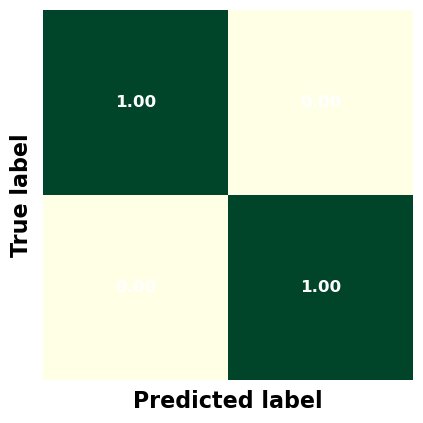

In [20]:
# Let's set the model to eval mode, and see its performance on a new random set
model = model.eval()
evaluate_model(model)